In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
from __future__ import print_function
import keras
from keras.layers import Conv2D,MaxPooling2D
from keras.layers import Dense,Flatten,Dropout,BatchNormalization
from keras.models import Sequential
from keras import backend as K

Using TensorFlow backend.


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator,load_img

In [4]:
import os

In [5]:
print(os.listdir("../my ML_stuff"))

['.ipynb_checkpoints', 'cats vs dogs.ipynb', 'dogs-vs-cats', 'mnist_cnn.ipynb', 'mnist_cnn_3.h5']


In [6]:
filenames = os.listdir("../my ML_stuff/dogs-vs-cats/train")

In [7]:
categories=[]

In [8]:
for filename in filenames:
    category= filename.split('.')[0]
    if category =='dog':
        categories.append(1)
    else:
        categories.append(0)

In [9]:
df = pd.DataFrame({'filename':filenames,'category':categories})

In [10]:
df.tail()

,filename,category
24995,dog.9995.jpg,1
24996,dog.9996.jpg,1
24997,dog.9997.jpg,1
24998,dog.9998.jpg,1
24999,dog.9999.jpg,1


In [11]:
df['category'].value_counts().plot.bar()

In [12]:
sample = random.choice(filenames)
image = load_img("../my ML_stuff/dogs-vs-cats/train/"+sample)
plt.imshow(image)

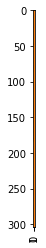

In [13]:
plt.show()

In [14]:
%matplotlib inline

In [15]:
FAST_RUN = False
IMAGE_WIDTH=128
IMAGE_HEIGHT=128
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3 # RGB color

In [16]:
model = Sequential()
model.add(Conv2D(32,(3,3),activation='relu',input_shape=(IMAGE_WIDTH,IMAGE_HEIGHT,IMAGE_CHANNELS)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(1,activation='sigmoid'))

model.compile(loss='binary_crossentropy',optimizer='rmsprop',metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 126, 126, 32)      896       
_________________________________________________________________
batch_normalization_1 (Batch (None, 126, 126, 32)      128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 63, 63, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 61, 61, 64)        18496     
_________________________________________________________________
batch_normalization_2 (Batch (None, 61, 61, 64)        256       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 30, 30, 64)        0         
__________

In [17]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [18]:
earlystop = EarlyStopping(patience=10)

In [19]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc',patience=2,verbose=1,factor=0.5,min_lr=0.0001)

In [20]:
callbacks =[earlystop,learning_rate_reduction]

In [21]:
train_df, validate_df = train_test_split(df, test_size=0.20, random_state=42)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

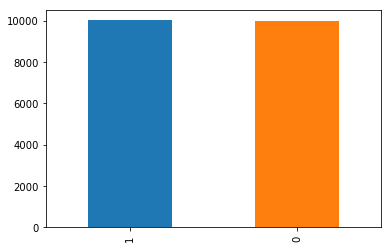

In [22]:
train_df['category'].value_counts().plot.bar()

In [23]:
total_train = train_df.shape[0]
total_validate = validate_df.shape[0]
batch_size=15

In [24]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    "../my ML_stuff/dogs-vs-cats/train/", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='binary',
    batch_size=batch_size
)

Found 20000 images belonging to 2 classes.


In [25]:
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    "../my ML_stuff/dogs-vs-cats/train/", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='binary',
    batch_size=batch_size
)

Found 5000 images belonging to 2 classes.


In [26]:
example_df = train_df.sample(n=1).reset_index(drop=True)
example_generator = train_datagen.flow_from_dataframe(
    example_df, 
    "../my ML_stuff/dogs-vs-cats/train/", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='binary'
)

Found 1 images belonging to 1 classes.


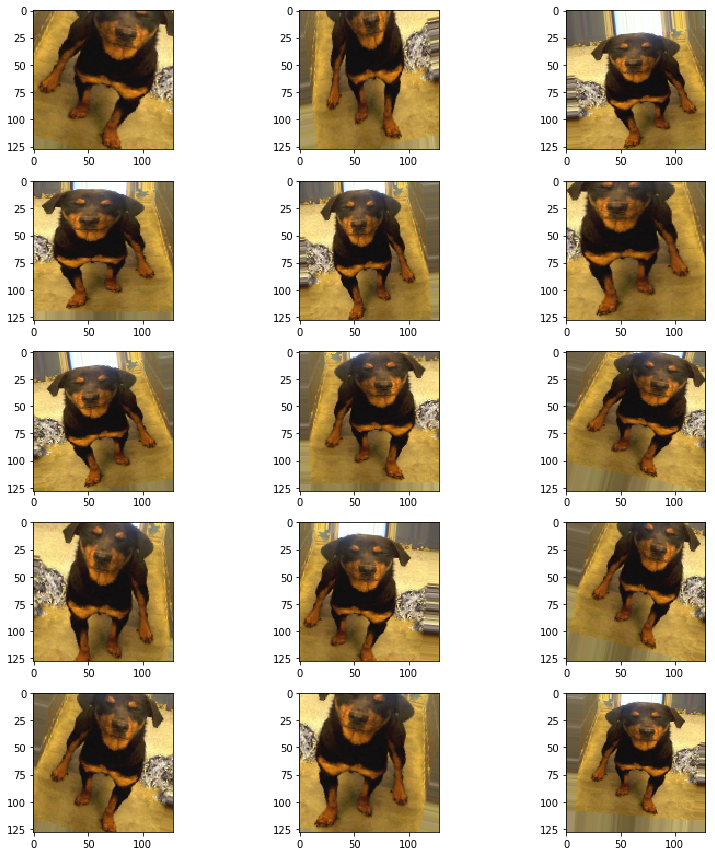

In [27]:
plt.figure(figsize=(12, 12))
for i in range(0, 15):
    plt.subplot(5, 3, i+1)
    for X_batch, Y_batch in example_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

In [ ]:
#epochs=3 if FAST_RUN else 50
epochs=1 if FAST_RUN else 1
history = model.fit_generator(
    train_generator, 
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    callbacks=callbacks
)

Epoch 1/1
1318/1333 [============================>.] - ETA: 52s - loss: 0.7032 - acc: 0.6411 8  

In [32]:
test_filenames = os.listdir("../my ML_stuff/dogs-vs-cats/test1")
test_df = pd.DataFrame({
    'filename': test_filenames
})
nb_samples = test_df.shape[0]

In [34]:
test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_dataframe(
    test_df, 
    "../my ML_stuff/dogs-vs-cats/test1", 
    x_col='filename',
    y_col=None,
    class_mode=None,
    target_size=IMAGE_SIZE,
    batch_size=batch_size,
    shuffle=False
)

Found 12500 images.


In [36]:
predict = model.predict_generator(test_generator, steps=np.ceil(nb_samples/batch_size))

In [37]:
threshold = 0.5
test_df['probability'] = predict
test_df['category'] = np.where(test_df['probability'] > threshold, 1,0)

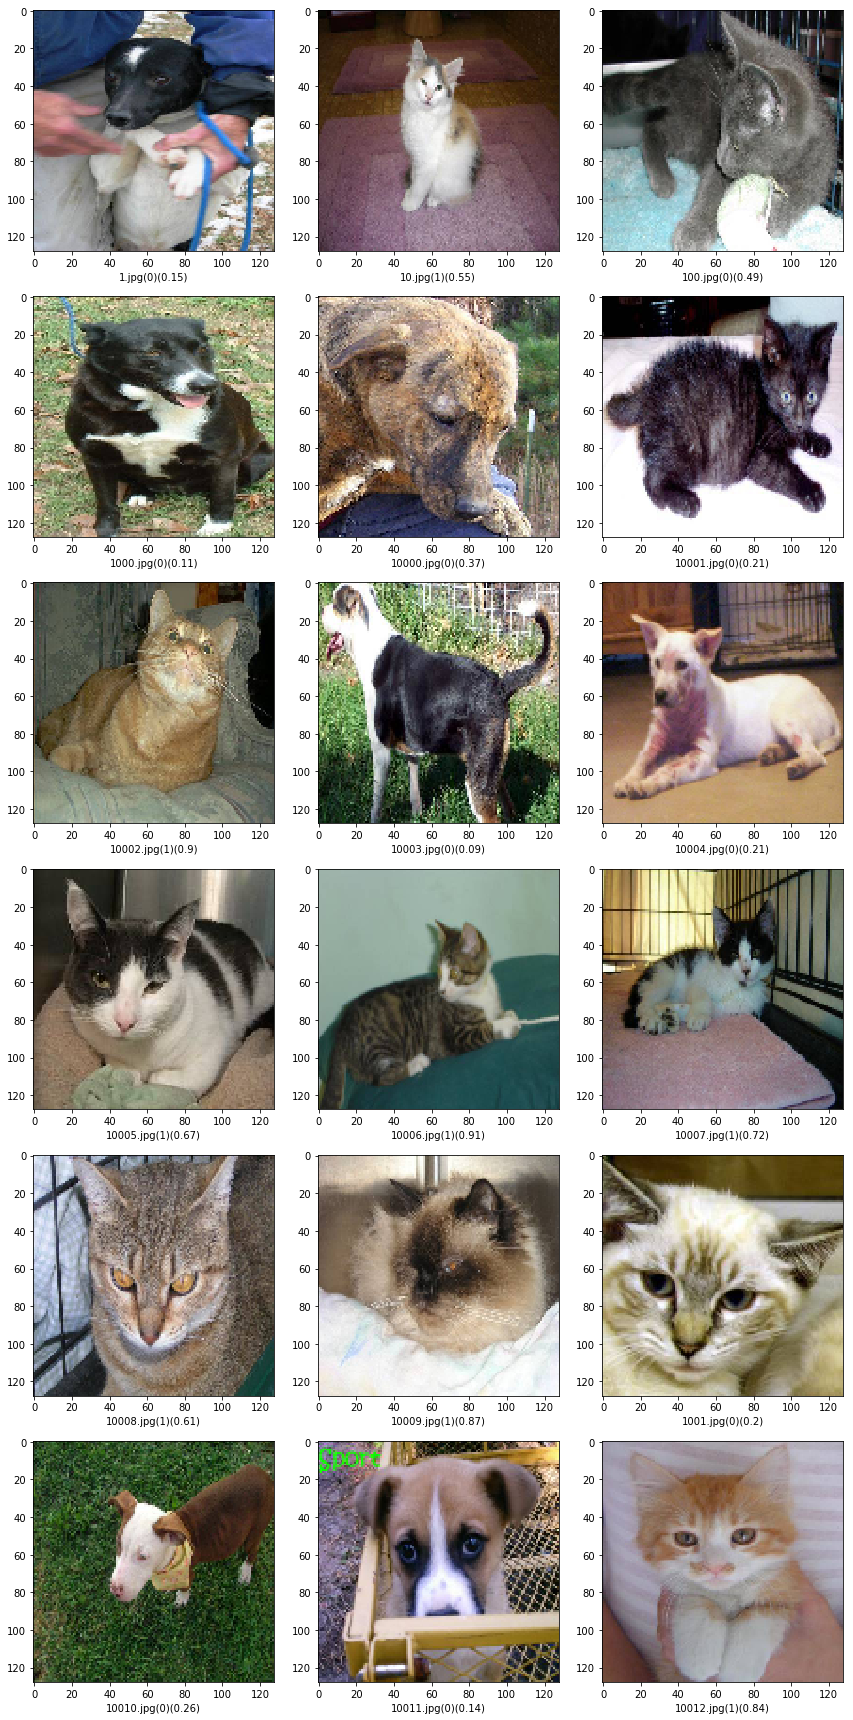

In [39]:
sample_test = test_df.head(18)
sample_test.head()
plt.figure(figsize=(12, 24))
for index, row in sample_test.iterrows():
    filename = row['filename']
    category = row['category']
    probability = row['probability']
    img = load_img("../my ML_stuff/dogs-vs-cats/test1/"+filename, target_size=IMAGE_SIZE)
    plt.subplot(6, 3, index+1)
    plt.imshow(img)
    plt.xlabel(filename + '(' + "{}".format(category) + ')' '(' + "{}".format(round(probability, 2)) + ')')
plt.tight_layout()
plt.show()

In [42]:
submission_df = test_df.copy()
submission_df['id'] = submission_df['filename'].str.split('.').str[0]
submission_df['label'] = submission_df['category']
submission_df.drop(['filename', 'category'], axis=1, inplace=True)
submission_df.to_csv('submission.csv', index=False)